In [1]:
pip install fdtd


Note: you may need to restart the kernel to use updated packages.


In [2]:
import fdtd

In [3]:
fdtd.set_backend("torch")

In [63]:
grid=fdtd.Grid(
    shape=(20e-6,30e-6,1),
    grid_spacing= 2e-7,
    permittivity= 1.0,
    permeability= 1.0,
    #courant_number: float = None,
)

In [25]:
grid = fdtd.Grid(
    shape = (25e-6, 15e-6, 1), # 25um x 15um x 1 (grid_spacing) --> 2D FDTD
)
print(grid)

Grid(shape=(161,97,1), grid_spacing=1.55e-07, courant_number=0.70)



In [64]:
grid[11:32, 30:84, 0] = fdtd.Object(permittivity=1.7**2, name="object1")

In [65]:
grid[10e-6:15e-6, 15e-6:20e-6, 0] = fdtd.Object(permittivity=1.5**2,name="object2")

In [66]:
print(grid.objects)

[Object(name='object1'), Object(name='object2')]


In [67]:
grid[7.5e-6:8.0e-6, 11.8e-6:13.0e-6, 0] = fdtd.LineSource(
    period = 1550e-9 / (3e8), name="source"
)

In [68]:
print(grid.source)

    LineSource(period=11, amplitude=1.0, phase_shift=0.0, name='source')
        @ x=[38, ... , 39], y=[59, ... , 64], z=[0, ... , 0]



In [69]:
grid[8e-6, :, 0] = fdtd.LineDetector(name="detector")

In [70]:
print(grid.detector)

    LineDetector(name='detector')
        @ x=[40, ... , 40], y=[0, ... , 149], z=[0, ... , 0]



In [71]:
grid[50:52, 60:70, 0] = fdtd.LineSource(
    period = 2e-7/3e8,cycle=10, name="source2"
)

In [73]:
# x boundaries
grid[0:10, :, :] = fdtd.PML(name="pml_xlow")
grid[-10:, :, :] = fdtd.PML(name="pml_xhigh")

# y boundaries
grid[:, 0:10, :] = fdtd.PML(name="pml_ylow")
grid[:, -10:, :] = fdtd.PML(name="pml_yhigh")

In [74]:
print(grid)

Grid(shape=(100,150,1), grid_spacing=2.00e-07, courant_number=0.70)

sources:
    LineSource(period=11, amplitude=1.0, phase_shift=0.0, name='source')
        @ x=[38, ... , 39], y=[59, ... , 64], z=[0, ... , 0]
    LineSource(period=100, amplitude=1.0, phase_shift=0.0, name='source2')
        @ x=[50, ... , 51], y=[60, ... , 69], z=[0, ... , 0]

detectors:
    LineDetector(name='detector')
        @ x=[40, ... , 40], y=[0, ... , 149], z=[0, ... , 0]

boundaries:
    PML(name='pml_xlow')
        @ x=0:10, y=:, z=:
    PML(name='pml_xhigh')
        @ x=-10:, y=:, z=:
    PML(name='pml_ylow')
        @ x=:, y=0:10, z=:
    PML(name='pml_yhigh')
        @ x=:, y=-10:, z=:

objects:
    Object(name='object1')
        @ x=11:32, y=30:84, z=0:1
    Object(name='object2')
        @ x=50:75, y=75:100, z=0:1



In [75]:
grid.run(total_time=1000)

100%|██████████| 1000/1000 [00:03<00:00, 254.94it/s]


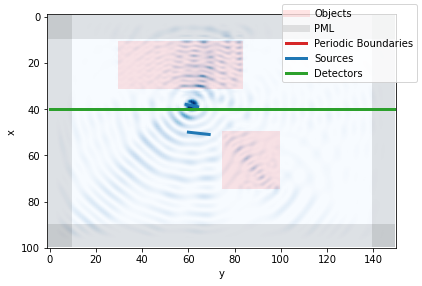

In [76]:
grid.visualize(z=0)

In [46]:
grid.update_H()
print(grid)

Grid(shape=(100,150,1), grid_spacing=2.00e-07, courant_number=0.70)

sources:
    LineSource(period=11, amplitude=1.0, phase_shift=0.0, name='source')
        @ x=[38, ... , 39], y=[59, ... , 64], z=[0, ... , 0]
    LineSource(period=11, amplitude=1.0, phase_shift=0.0, name='source2')
        @ x=[50, ... , 51], y=[60, ... , 69], z=[0, ... , 0]

detectors:
    LineDetector(name='detector')
        @ x=[40, ... , 40], y=[0, ... , 149], z=[0, ... , 0]

boundaries:
    PML(name='pml_xlow')
        @ x=0:10, y=:, z=:
    PML(name='pml_xhigh')
        @ x=-10:, y=:, z=:
    PML(name='pml_ylow')
        @ x=:, y=0:10, z=:
    PML(name='pml_yhigh')
        @ x=:, y=-10:, z=:

objects:
    Object(name='object1')
        @ x=11:32, y=30:84, z=0:1
    Object(name='object2')
        @ x=50:75, y=75:100, z=0:1



In [40]:
def curl_E(E):
    curl_E = np.zeros(E.shape)
    curl_E[:,:-1,:,0] += E[:,1:,:,2] - E[:,:-1,:,2]
    curl_E[:,:,:-1,0] -= E[:,:,1:,1] - E[:,:,:-1,1]

    curl_E[:,:,:-1,1] += E[:,:,1:,0] - E[:,:,:-1,0]
    curl_E[:-1,:,:,1] -= E[1:,:,:,2] - E[:-1,:,:,2]

    curl_E[:-1,:,:,2] += E[1:,:,:,1] - E[:-1,:,:,1]
    curl_E[:,:-1,:,2] -= E[:,1:,:,0] - E[:,:-1,:,0]
    return curl_E

In [41]:
def curl_H(H):
    curl_H = np.zeros(H.shape)

    curl_H[:,1:,:,0] += H[:,1:,:,2] - H[:,:-1,:,2]
    curl_H[:,:,1:,0] -= H[:,:,1:,1] - H[:,:,:-1,1]

    curl_H[:,:,1:,1] += H[:,:,1:,0] - H[:,:,:-1,0]
    curl_H[1:,:,:,1] -= H[1:,:,:,2] - H[:-1,:,:,2]

    curl_H[1:,:,:,2] += H[1:,:,:,1] - H[:-1,:,:,1]
    curl_H[:,1:,:,2] -= H[:,1:,:,0] - H[:,:-1,:,0]
    return curl_H

In [42]:
    E  += (c*dt/du)*inv(ε)*curl_H
    H  -= (c*dt/du)*inv(µ)*curl_E

NameError: name 'E' is not defined

In [43]:
class Grid:
    # ... [initialization]

    def step(self):
        self.update_E()
        self.update_H()

    def update_E(self):
        self.E += self.courant_number * self.inverse_permittivity * curl_H(self.H)

    def update_H(self):
        self.H -= self.courant_number * self.inverse_permeability * curl_E(self.E)